## Итоговое задание Анны Лубневской  
### по Проекту 6. Выбираем авто выгодно 
###  Юнит 7. Основные алгоритмы машинного обучения. Часть II 


### Описание
Представьте, что вы работаете в компании, которая занимается продажей автомобилей с пробегом. Основная задача компании и ее менеджеров - максимально быстро находить выгодные предложения (проще говоря, купить ниже рынка, а продать дороже рынка).

Вам поставлена задача создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам.
Если наша модель работает хорошо, то мы сможем быстро выявлять выгодные предложения (когда желаемая цена продавца ниже предсказанной рыночной цены). Это значительно ускорит работу менеджеров и повысит прибыль компании.

### Данные
Компания изначально не собирала данные. Есть только небольшой датасет с историей продаж, которого для обучения модели мало. 
### Задача

Собрать данные для тренировочного набора, обработать эти данные и обучить на этих данных различные модели машинного обучения. По результатам с помощью метрики MAPE (Mean Percentage Absolute Error) выбрать модель, которая будет более точно предсказывать стоимость автомобиля по его характеристикам.

### 2. Машинное обучение.

В этом ноутбуке опробованы различные алгоритмы машинного обучения и проведено сравнение результатов. Рассмотрены алгоритмы:

- RandomForestRegressor 
- ExtraTreesRegressor 
- LGBMRegressor 
- CatBoostRegressor 
- StackingRegressor  

_Внимание:_ требовательно к ресурсам компьютера! Датасет большой, а также виду сжатых  сроков оптимизация не проводилась. Полный прогон ноутбука занимает около 11 часов и требует порядка 30 гБ оперативной памяти.

In [166]:
# загружаем бибилиотеки
import os
import time
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_selection import f_regression, mutual_info_regression

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge

from sklearn.model_selection import cross_val_score, KFold,RepeatedKFold, StratifiedKFold
from tqdm.notebook import tqdm

import warnings 
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500) 
sns.set(rc={'figure.figsize': (8, 5)}) 
plt.style.use('seaborn-deep')

In [ ]:
RANDOM_SEED = 42

### Функции

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """
    Вычисляет метрику MAPE - среднюю абсолютную ошибку в процентах

    :param:   y_true - реальная стоимость автомобиля
              y_pred - предсказанная стоимость автомобиля
    :return: значение метрики MAPE
    """
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred))))

def percentage_error(actual, predicted):
    """
    Вычисляет и выводит 
    :param:  actual - 
             predicted - 
    :return: res - 

    """
    
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res


def cat_plot(col, rotation=90):
    """
    Строит бар-плот для категориальных признаков
    :param:  col - название колонки
    
    """
    df = train[col].value_counts()
    plt.title(f'Распределение {col}', fontsize=15)
    sns.barplot(x=df.index, y=df.values, palette='Blues_r_d')
    plt.xticks(rotation=rotation);  
    
def cat_boxplot(col, rotation=90):
    """
    Строит бокс-плот для категориальных признаков
    :param:  col - название колонки
    
    """
    plt.title(f'Распределение цен на авто от значений {col}', fontsize=15)
    sns.boxplot(x=col, y='price', data=train, palette='Blues_r_d')
    plt.xticks(rotation=rotation);  
    
def check_values(col):
    """
     Проверяет, есть ли принимаемые значения признака одновременно в тренировочном и в тестовом дата сетах
     :param:  col - название колонки
   
    """
    train_col = set(train[col].unique())
    test_col = set(test[col].unique())
    result = test_col - train_col
    if len(result) == 0:
        print('Все уникальные значения test присутствуют в train')
    else:
        print(f'В train.{col} нет значений: {result}')
    
def equipment_top(cell):
    x = 0
    for i in equipment_top_lst:
        if i in cell:
            x += 1
    return x

def equipment_rare(cell):
    x = 0
    for i in equipment_rare_lst:
        if i in cell:
            x += 1
    return x

def enginePower_rate(power):
    """ 
    Присваивает значение рейта/ тарифа в зависимости от 
     мощности двигателя :param:  power - значение мощности двигателя 
     
     """
    if power > 250:
        return 150
    elif power > 225:
        return 75
    elif power > 200:
        return 65
    elif power > 175:
        return 50
    elif power > 150:
        return 45
    elif power > 125:
        return 35
    elif power > 100:
        return 25
    else:
        return 12
    
def stacking_model_predict(d_models, d_X_train, d_y_train, d_X_val):
    d_df = pd.DataFrame()
    for model_ in tqdm(d_models):
        model_.fit(d_X_train, d_y_train)
        y_pred = model_.predict(d_X_val)
        d_df[str(model_)[:6]] = np.exp(y_pred)                   
    return d_df

### Первичный просмотр и подготовка данных

Для предсказания стоимости автомобилей мной были иcпользованы данные с сайта авто.ру. Данные получены с помощью парсинга и библиотек Request и Beautiful Soup (подробнее в ноутбуке по парсингу).

In [3]:
train = pd.read_csv('big_train_LR.csv')
train.drop('Unnamed: 0', axis=1, inplace=True)
test = pd.read_csv('test_LR.csv')

Проведем предварительную общую оценку данных

In [4]:
print('train:', train.shape)
print('test:', test.shape)

train: (129321, 33)
test: (34686, 32)


В тренировочном дата сете 129321 и в тестовом - 34686 записей об автомобилях. Имеется 33 и 32 колонки о характеристиках этих автомобилей, из которых 9 (6) числовых и 24 (26) категориальных. Возможно, придется привести признаки к общему типу данных или изменить его. Тестовый набор имеет на одну колонку меньше, так как не включена колонка о ценах на автомобили.

### Датасет

Название колонки | Описание
:-- | :--
__bodyType__ | тип кузова
__brand__ |марка автомобиля 
__car_url__ | ссылка на автомобиль
__color__ | цвет автомобиля
__complectation_dict__  | комплектация (словарь)
__description__ | описание
__engineDisplacement__ | объем двигателя
__enginePower__ | мощность двигателя
__equipment_dict__ | комплектация(словарь)
__fuelType__ | тип топлива (значения: бензин,дизель, электро, гибрид, газ)
__image__ | фотография/изображение
__mileage__ | пробег (километры)
__modelDate__ | дата модели
__model_info__ | информация о модели
__model_name__ | название модели
__name__ | наименование двигатель и тип трансмиссии
__numberOfDoors__ | количество дверей
__parsing_unixtime__ | дата время парсинга
__priceCurrency__ | валюта для цены
__productionDate__ | дата производства
__sell_id__ | идентификатор продажи
__super_gen__ |  дополнительная информация          
__vehicleConfiguration__ | конфигурация автомобиля
__vehicleTransmission__ | трансмиссия / коробка передач (значения:механическая, автоматическая, вариатор, роботизированная)
__vendor__ | производитель              
__Владельцы__ | количество предыдущих владельцев (значения: 1, 2, 3 и более)
__Владение__ | владение            
__ПТС__ | наличие/ отсутствие ПТС
__Привод__ | тип привода (значения: передний, задний,полный)              
__Руль__ | расположение руля (значения: левый / правый)
__Состояние__ | состояние автомобиля (значения: требует / не требует ремонта)
__Таможня__ | ратоможен/нерастоможен

In [5]:
print('train:')
display(train.head(3))
print()
print('test:')
display(test.head(3))

train:


,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,parsing_unixtime
0,седан,AUDI,https://auto.ru/cars/used/sale/audi/100/108027...,голубой,NaN,Куплена не в кредит. Своевременное обслуживани...,2.3 LTR,133 N12,"{'tinted-glass': True, 'abs': True, 'wheel-pow...",бензин,https://autoru.naydex.net/1gek7D451/db78d3X7bE...,410000.0,1990.0,"{'code': '100', 'name': '100', 'ru_name': '100...",100,2.3 MT (133 л.с.),4.0,RUB,1993.0,1.080280e+09,"{'id': '7879487', 'displacement': 2309, 'engin...",SEDAN MECHANICAL 2.3,механическая,NaN,3 или более,4 года и 3 месяца,Дубликат,передний,Левый,Не требует ремонта,Растаможен,160000.0,NaN
1,седан,AUDI,https://auto.ru/cars/used/sale/audi/100/109156...,серебристый,NaN,Авто на ходу езжу каждый день имеются косяки ...,2.6 LTR,150 N12,"{'tinted-glass': True, '16-inch-wheels': True,...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,350000.0,1990.0,"{'code': '100', 'name': '100', 'ru_name': '100...",100,2.6 AT (150 л.с.),4.0,RUB,1993.0,1.091567e+09,"{'id': '7879494', 'displacement': 2598, 'engin...",SEDAN AUTOMATIC 2.6,автоматическая,NaN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,150000.0,NaN
2,седан,AUDI,https://auto.ru/cars/used/sale/audi/100/109599...,серый,NaN,"Продам Audi 100 c3 90г. Машина не идеальна, ез...",2.3 LTR,136 N12,{},бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,453000.0,1988.0,"{'code': '100', 'name': '100', 'ru_name': '100...",100,2.3 MT (136 л.с.),4.0,RUB,1990.0,1.095993e+09,"{'id': '21188602', 'displacement': 2309, 'engi...",SEDAN MECHANICAL 2.3,механическая,NaN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,70000.0,NaN



test:


,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [6]:
# удаляем дубликаты
train = train.drop_duplicates()
train.duplicated().sum()

0

In [7]:
# проверяем количество строк после удаления 
train.shape

(126416, 33)

In [8]:
test.shape

(34686, 32)

In [9]:
# добавляем колонку с длиной описания
train['len_description'] = train.description.apply(lambda x: len(str(x)))
test['len_description'] = test.description.apply(lambda x: len(str(x)))

Рассмотрим общие статитстические показатели по данным в обоих датасетах

In [10]:
train.describe()

,complectation_dict,mileage,modelDate,numberOfDoors,productionDate,sell_id,vendor,price,parsing_unixtime,len_description
count,0.0,126348.000000,126347.000000,126347.000000,126348.000000,1.263480e+05,0.0,1.187700e+05,1.167440e+05,126416.000000
mean,NaN,169931.329724,2006.691350,4.470221,2008.824034,1.100960e+09,NaN,1.259948e+06,1.618694e+09,725.735049
std,NaN,107016.531932,8.136167,0.674591,7.816050,1.343370e+07,NaN,1.478903e+06,2.630685e+04,822.389250
min,NaN,1.000000,1934.000000,2.000000,1934.000000,2.665000e+03,NaN,2.000000e+04,1.618656e+09,1.000000
25%,NaN,90948.000000,2002.000000,4.000000,2004.000000,1.101807e+09,NaN,4.100000e+05,1.618684e+09,176.000000
50%,NaN,155818.000000,2008.000000,5.000000,2011.000000,1.102770e+09,NaN,8.000000e+05,1.618695e+09,419.000000
75%,NaN,231344.000000,2013.000000,5.000000,2015.000000,1.103060e+09,NaN,1.580000e+06,1.618703e+09,1005.000000
max,NaN,1000000.000000,2020.000000,5.000000,2021.000000,1.103342e+09,NaN,4.000000e+07,1.618834e+09,29427.000000


In [11]:
test.describe()

,mileage,modelDate,numberOfDoors,parsing_unixtime,productionDate,sell_id,len_description
count,34686.000000,34686.000000,34686.000000,3.468600e+04,34686.000000,3.468600e+04,34686.000000
mean,162009.767889,2007.074728,4.450816,1.603287e+09,2009.264602,1.098300e+09,642.407340
std,100676.559489,7.415894,0.703040,1.493071e+05,7.047661,1.911225e+07,778.750118
min,1.000000,1904.000000,0.000000,1.603107e+09,1904.000000,2.665000e+03,1.000000
25%,91153.500000,2004.000000,4.000000,1.603221e+09,2006.000000,1.099049e+09,167.000000
50%,149779.500000,2008.000000,5.000000,1.603254e+09,2011.000000,1.100911e+09,371.000000
75%,215000.000000,2012.000000,5.000000,1.603290e+09,2014.000000,1.101245e+09,869.000000
max,1000000.000000,2020.000000,5.000000,1.603710e+09,2020.000000,1.101375e+09,28789.000000


### Целевая переменная и удаление ненужных признаков

In [12]:
# создаем список колонок на удаление
col_drop = ['car_url', 'complectation_dict', 'description', 'image', 'model_info',
            'name', 'parsing_unixtime', 'priceCurrency', 'sell_id', 'vehicleConfiguration']

In [13]:
# удаляем ненужные колонки
train.drop(col_drop, axis=1, inplace=True)
test.drop(col_drop, axis=1, inplace=True)

Посмотрим на распределение целевой переменной

In [14]:
train.dropna(subset=['price'], inplace=True)

Логорифмируем таргет

In [15]:
train.price = np.log(train.price)

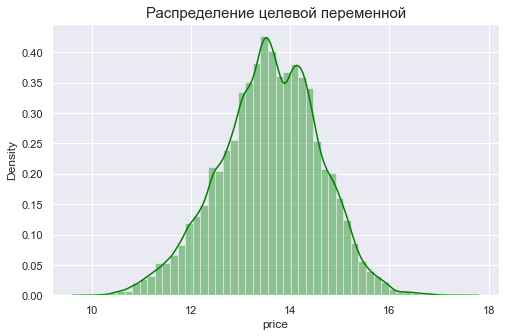

In [16]:
plt.title('Распределение целевой переменной', fontsize=15)
sns.distplot(train.price, color='green');

### Работа с пропусками

In [17]:
# проверим количество пропусков
print('train:')
display(train.isna().sum()[train.isna().sum() > 0])
print()
print('test:')
display(test.isna().sum()[test.isna().sum() > 0])

train:


bodyType                    1
fuelType                    1
modelDate                   1
numberOfDoors               1
super_gen                   1
vehicleTransmission         1
vendor                 118770
Владельцы                   5
Владение                84392
ПТС                         6
Привод                      1
dtype: int64


test:


equipment_dict     9996
Владение          22691
ПТС                   1
dtype: int64

Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'equipment_dict', 'fuelType', 'mileage', 'modelDate', 'model_name',
       'numberOfDoors', 'productionDate', 'super_gen', 'vehicleTransmission',
       'vendor', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние',
       'Таможня', 'price', 'len_description'],
      dtype='object')


<AxesSubplot:>

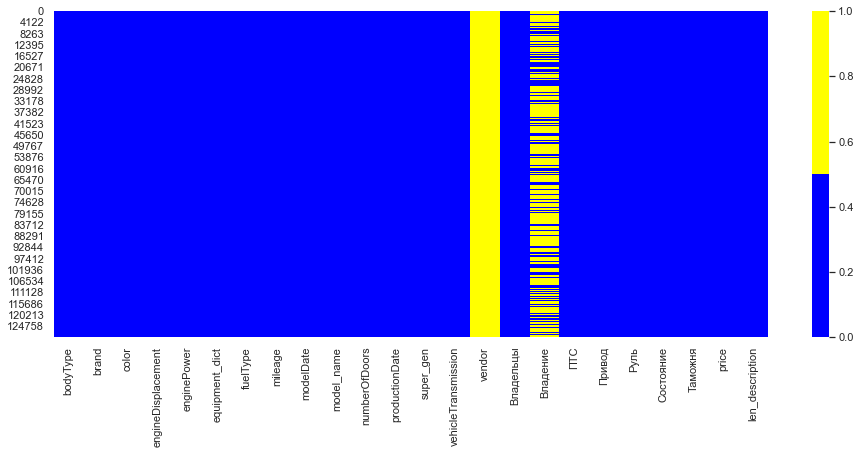

In [18]:
# Посмотрим на пропуски на heat_map для наглядности
cols_train = train.columns
print(cols_train)
colours = ['blue', 'yellow']
plt.figure(figsize=(16, 6))
sns.heatmap(train.isnull(), cmap=sns.color_palette(colours))

Пока нет данных по производителям, мы заполним ту колонку на основании марки машины. Видно, что очень много пропусков в колонке Владение и есть пропуски в колонке цена. Остальные пропуски столь незначительны, что практически не различимы на диаграмме, в дальнейшем предполагается удалить или заполнить строки с пропусками.
Построим такую же диаграмму по пропускам в тестовом наборе данных

Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'equipment_dict', 'fuelType', 'mileage', 'modelDate', 'model_name',
       'numberOfDoors', 'productionDate', 'super_gen', 'vehicleTransmission',
       'vendor', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние',
       'Таможня', 'len_description'],
      dtype='object')


<AxesSubplot:>

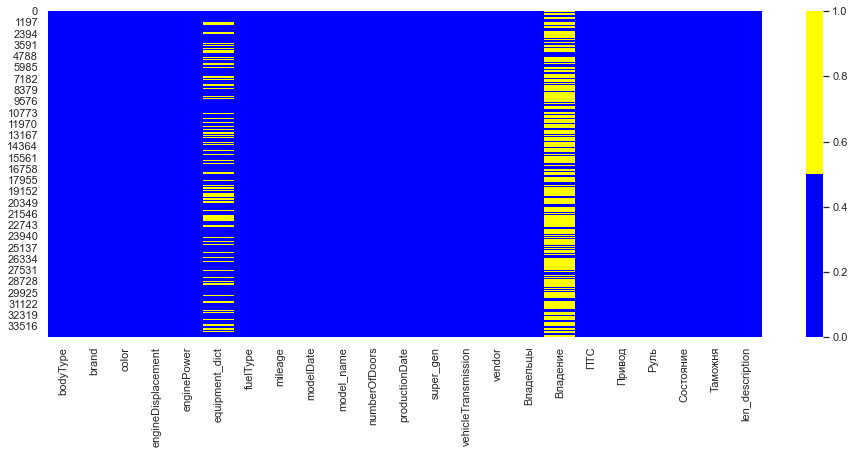

In [19]:
cols_test = test.columns
print(cols_test)
colours = ['blue', 'yellow']
plt.figure(figsize=(16, 6))
sns.heatmap(test.isnull(), cmap=sns.color_palette(colours))

В тестовом наборе данных большой процент пропусков в колонках complectation_dict, equipment_dict и Владение

In [20]:
# удаляем неинформативные колонки
train.dropna(subset=['ПТС', 'bodyType', 'Владельцы'], inplace=True)

In [21]:
# создаем списки по европейским и японским производителям и заполняем колонку Vendor
european = ['SKODA', 'AUDI', 'VOLVO', 'BMW', 'MERCEDES', 'VOLKSWAGEN']
japanese = ['HONDA', 'NISSAN', 'INFINITI', 'TOYOTA', 'LEXUS', 'MITSUBISHI']

train.loc[train.brand.isin(european), 'vendor'] = 'EUROPEAN'
train.loc[train.brand.isin(japanese), 'vendor'] = 'JAPANESE'

In [22]:
# Пропуски в колонке ПТС заменяем модой
test['ПТС'].fillna(train.ПТС.mode()[0], inplace=True)
test.equipment_dict.fillna('{}', inplace=True)

In [23]:
# проверяем нулевые значения еще раз
print('train:')
display(train.isna().sum()[train.isna().sum() > 0])
print()
print('test:')
display(test.isna().sum()[test.isna().sum() > 0])

train:


Владение    84381
dtype: int64


test:


Владение    22691
dtype: int64

Сгруппируем признаки в  категории по типу их обработки (категориальные, числовые, признаки состоящие из словарей) для дальнейшего удобного анализа. 

In [24]:
num_cols = ['mileage', 'modelDate', 'numberOfDoors', 'productionDate']
cat_cols = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
            'fuelType', 'model_name', 'vehicleConfiguration', 'vehicleTransmission', 
            'vendor', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня']
dict_col = ['equipment_dict', 'super_gen']

In [25]:
train.reset_index(drop=True, inplace=True)

In [26]:
# приводим числовые колонки к одному типу
train[num_cols] = train[num_cols].astype('int64')
test[num_cols] = test[num_cols].astype('int64')

### Числовые признаки

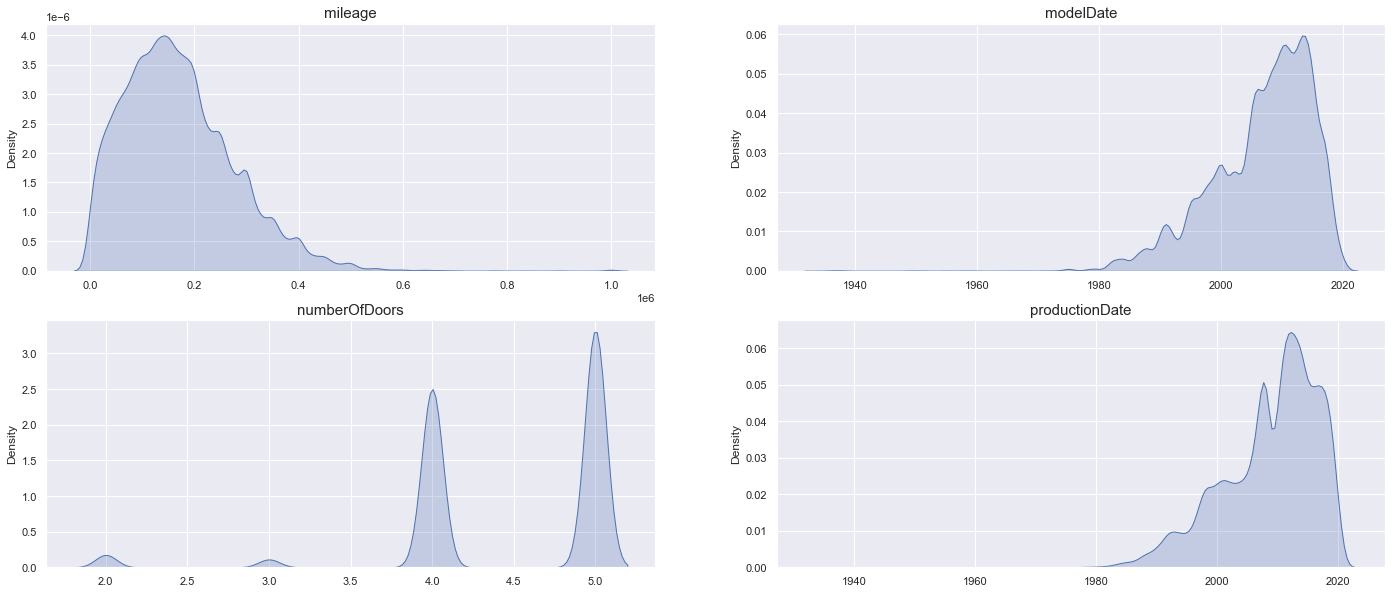

In [27]:
plt.figure(figsize=(24,10))
for i, col in enumerate(num_cols):
    plt.subplot(2,2, i+1)
    plt.title(col, fontsize=15)
    sns.kdeplot(x=col, data=train, shade=True)
    plt.xlabel(None)  

На основе этих графиков можно сделать вывод, что пробег состявляет у большигства машин и для некоторых машин в пределе до . По второму графику слава основные категории состявляют 4-5 дверные машины, имеется небольшой процент 2-х и 3-х дверных машин. Графики для modelDate и productionDate в целом очень похожи. Представленные машины были произведены в период с 1980 по 2020 годы (также имеются и более ранние машины, но их очень мало). Основную массу составляют машины примерно, начиная с 2010 года.

### Категориальные признаки

### bodyType

In [28]:
# смотрим на распределение по типу кузова
train.bodyType = train.bodyType.str.findall(r'^\S+').str[0]
test.bodyType = test.bodyType.str.findall(r'^\S+').str[0]

5 наиболее популярных значений - это внедорожник, седан, хэтчбек, лифтбек и универсал, из которых первые два составляют основную массу

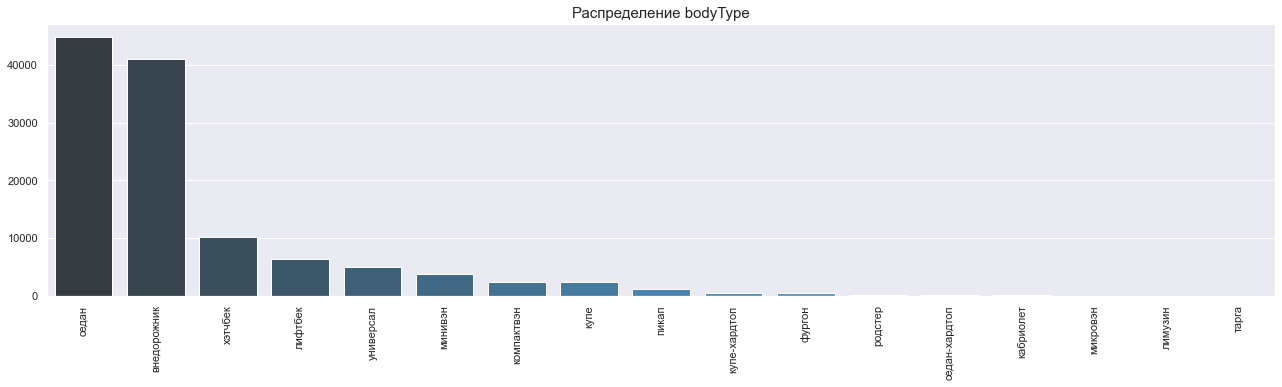

In [29]:
plt.figure(figsize=(22,5))
cat_plot('bodyType')

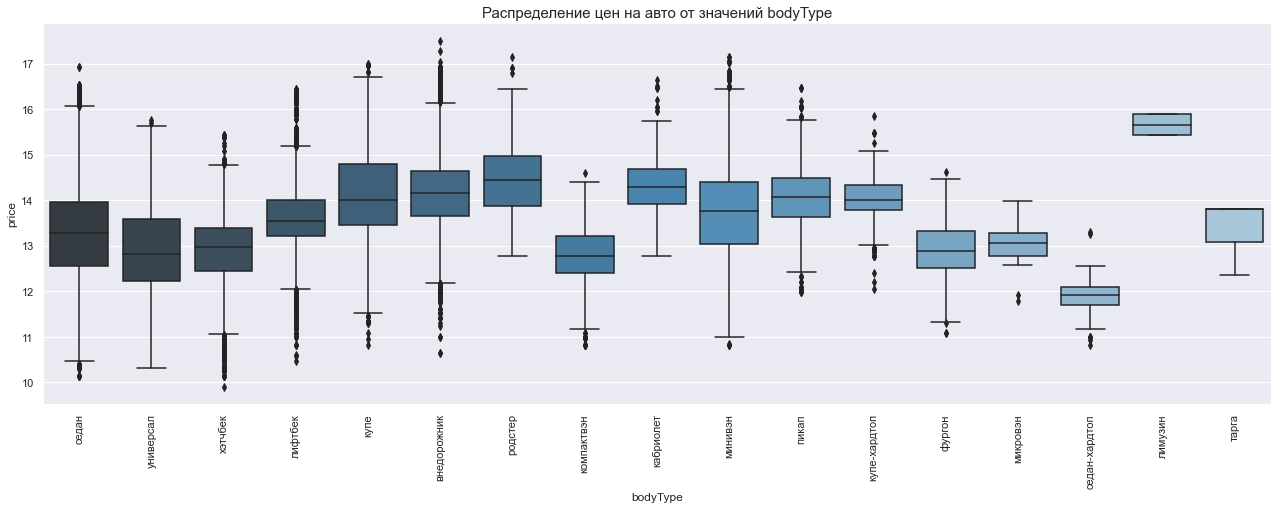

In [30]:
plt.figure(figsize=(22,7))
cat_boxplot('bodyType')

In [31]:
check_values('bodyType')

В train.bodyType нет значений: {'фастбек'}


In [32]:
test.loc[test.bodyType == 'фастбек', 'bodyType'] = 'хэтчбек'

### brand

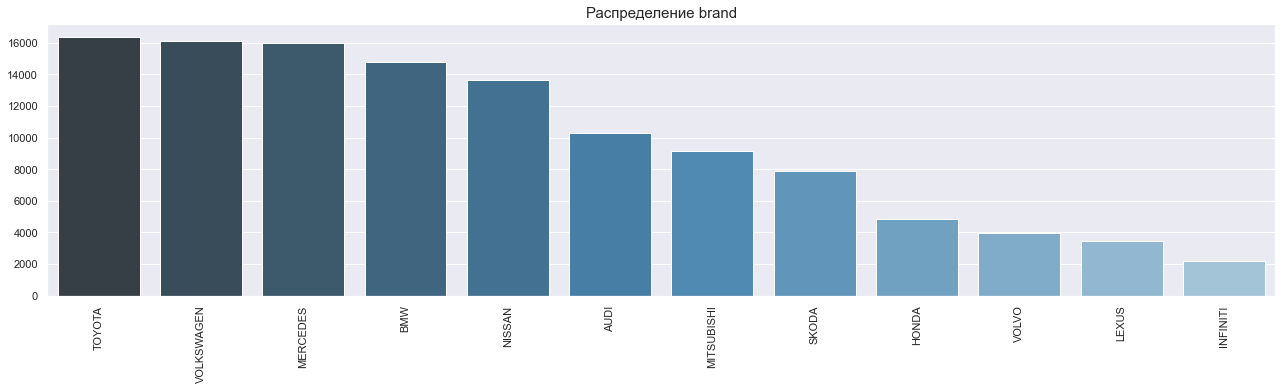

In [33]:
# смотрим на распределение по бренду
plt.figure(figsize=(22,5))
cat_plot('brand')

Популярны бенды: VOLKSWAGEN, BMW, MERCEDES, TOYOTA, NISSAN, AUDI, SKODA, MITSUBISHI и менее популярны VOLVO, HONDA, LEXUS, INFINITI

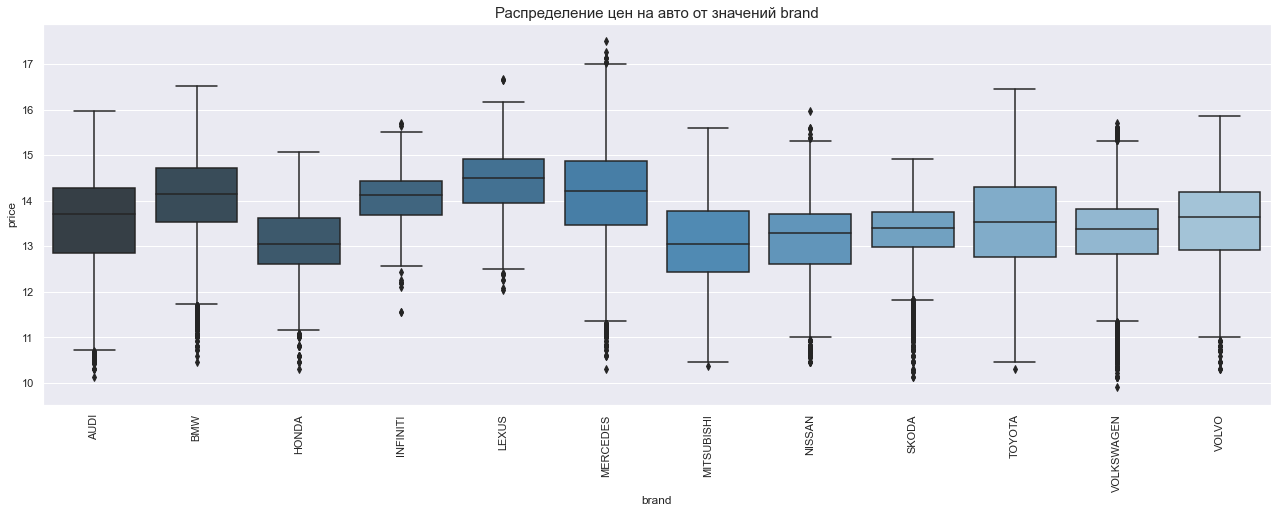

In [34]:
plt.figure(figsize=(22,7))
cat_boxplot('brand')

In [35]:
check_values('brand')

Все уникальные значения test присутствуют в train


### color

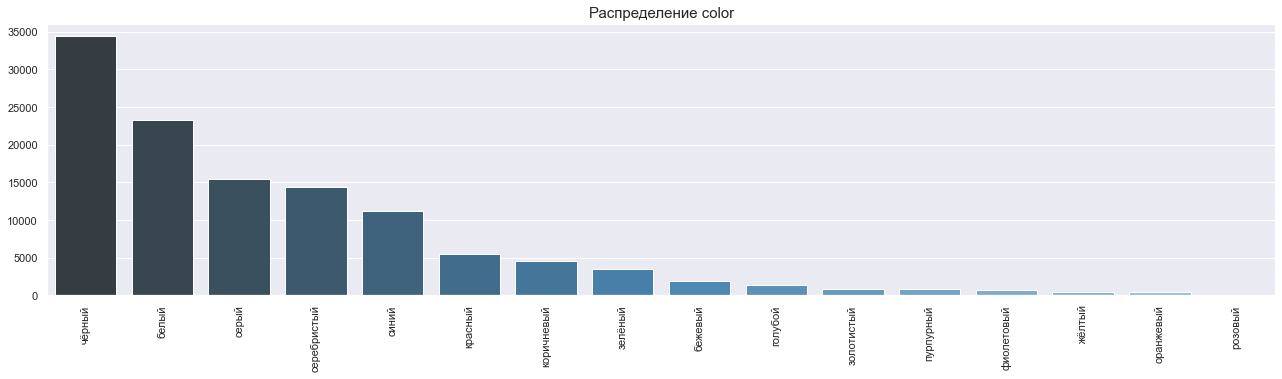

In [36]:
plt.figure(figsize=(22,5))
cat_plot('color')

Часто встречающиеся популярные цвета - это черный, белый, серый, серебристый. Редко встречаются фиолетовый, желтый, оранжевый, розовый. Всего 16 уникальных значений

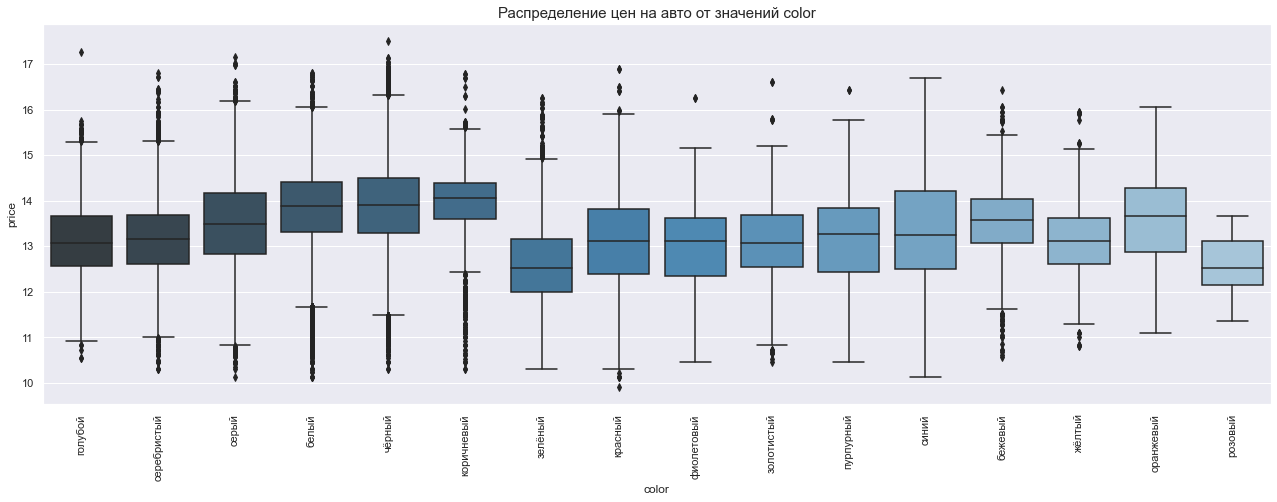

In [37]:
plt.figure(figsize=(22,7))
cat_boxplot('color')

In [38]:
check_values('color')

Все уникальные значения test присутствуют в train


### engineDisplacement

In [39]:
# смотрим на распределение по объему двигателя
train.engineDisplacement = train.engineDisplacement.str.findall(r"\d.\d").str[0]
train.engineDisplacement.fillna('0', inplace=True)

test.engineDisplacement = test.engineDisplacement.str.findall(r"\d.\d").str[0]
test.engineDisplacement.fillna('0', inplace=True)


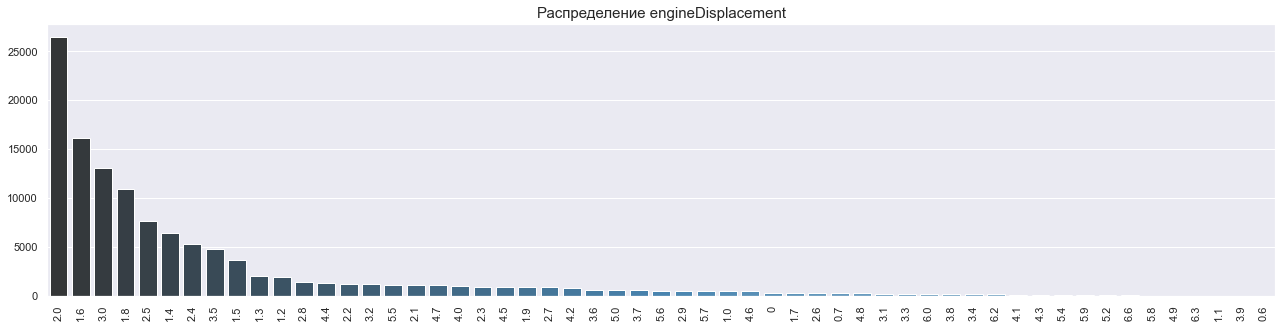

In [40]:
plt.figure(figsize=(22,5))
cat_plot('engineDisplacement', rotation=90)

In [41]:
check_values('engineDisplacement')

В train.engineDisplacement нет значений: {'5.3'}


In [42]:
# приводим значение колонки типу float64
train.engineDisplacement = train.engineDisplacement.astype('float64')
test.engineDisplacement = test.engineDisplacement.astype('float64')

### enginePower

In [43]:
# смотрим на распределение по мощности двигателя
train.enginePower = train.enginePower.str.findall(r'^\S+').str[0]
train.enginePower = train.enginePower.apply(lambda x: int(x))

test.enginePower = test.enginePower.str.findall(r'^\S+').str[0]
test.enginePower = test.enginePower.apply(lambda x: int(x))

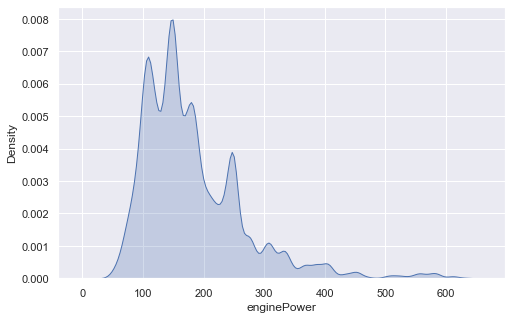

In [44]:
sns.kdeplot(x='enginePower', data=train, shade=True);

In [45]:
train['enginePower_rate'] = train.enginePower.apply(enginePower_rate)
test['enginePower_rate'] = test.enginePower.apply(enginePower_rate)

train['tax'] = train.enginePower_rate * train.enginePower
test['tax'] = test.enginePower_rate * test.enginePower

In [46]:
train.drop('enginePower_rate', axis=1, inplace=True)
test.drop('enginePower_rate', axis=1, inplace=True)

### fuelType

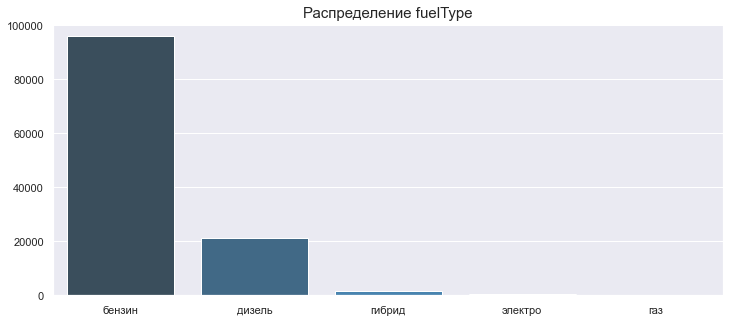

In [47]:
# смотрим на распределение по типу топлива
plt.figure(figsize=(12,5))
cat_plot('fuelType', rotation=0)

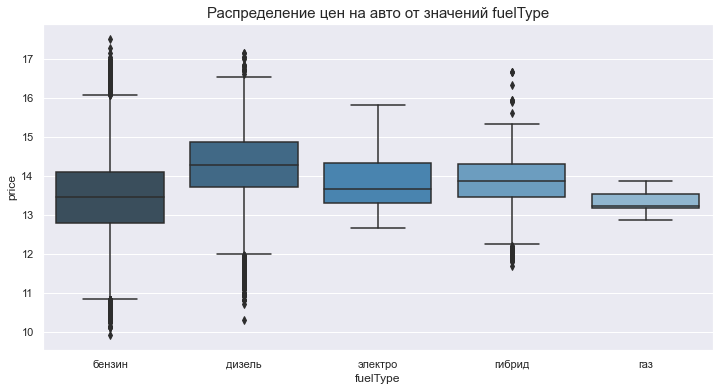

In [48]:
plt.figure(figsize=(12,6))
cat_boxplot('fuelType', rotation=0)

In [49]:
check_values('fuelType')

Все уникальные значения test присутствуют в train


### model_name

In [50]:
check_values('model_name')

В train.model_name нет значений: {'E3', 'M1', 'POPULAR', 'TT_RS', '100_SERIES', 'SLC_KLASSE', 'SIMPLEX', '140', 'CALIFORNIA', 'EUROVAN', '100NX', 'ATLAS', '280ZX', 'GRANVIA', 'ORIGIN', 'V60', 'TARO', 'VERSO_S', 'GOLF_R32'}


In [51]:
train['model_name_hash'] = train.model_name.apply(lambda x: abs(hash(x)))
test['model_name_hash'] = test.model_name.apply(lambda x: abs(hash(x)))

In [52]:
scaler = StandardScaler()
train['model_name_hash'] = scaler.fit_transform(train[['model_name_hash']])
test['model_name_hash'] = scaler.transform(test[['model_name_hash']])

In [53]:
train.drop('model_name', axis=1, inplace=True)
test.drop('model_name', axis=1, inplace=True)

### vehicleTransmission

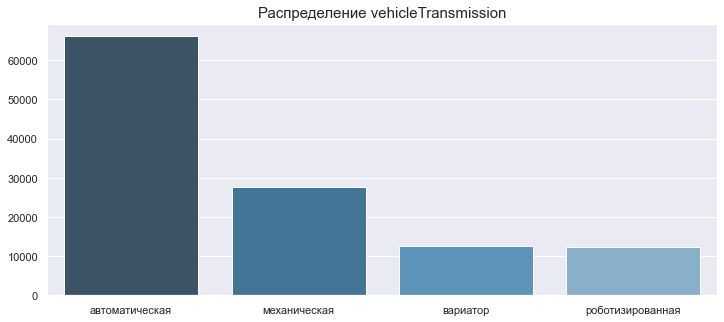

In [54]:
# смотрим на распределение по коробке передач
plt.figure(figsize=(12,5))
cat_plot('vehicleTransmission', rotation=0)

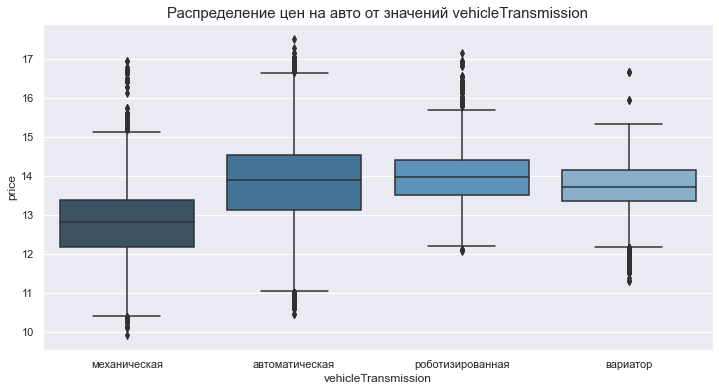

In [55]:
plt.figure(figsize=(12,6))
cat_boxplot('vehicleTransmission', rotation=0)

In [56]:
check_values('vehicleTransmission')

Все уникальные значения test присутствуют в train


### vendor

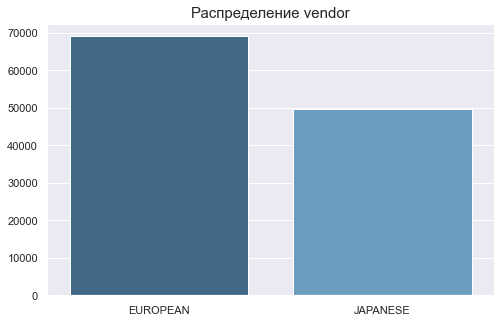

In [57]:
# смотрим на распределение по производителю
cat_plot('vendor', rotation=0)

Европейских машин больше, чем японских примерно в 1,5 раза

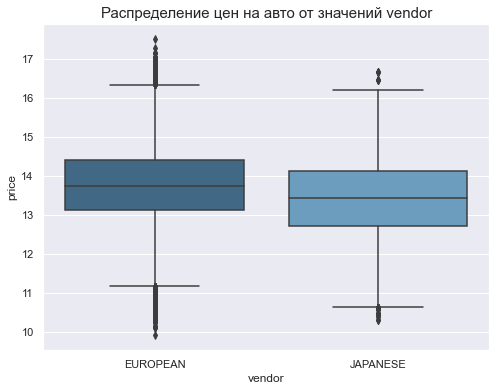

In [58]:
plt.figure(figsize=(8,6))
cat_boxplot('vendor', rotation=0)

In [59]:
check_values('vendor')

Все уникальные значения test присутствуют в train


In [60]:
vendor_dict = {'EUROPEAN': 0, 'JAPANESE': 1}

train.vendor = train.vendor.map(vendor_dict)
test.vendor = test.vendor.map(vendor_dict)

### Владельцы

In [61]:
# смотрим на распределение по количеству владельцев
train.Владельцы = train.Владельцы.str.findall('\d').str[0]
test.Владельцы = test.Владельцы.str.findall('\d').str[0]

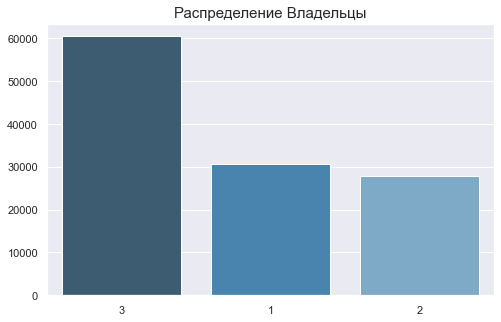

In [62]:
cat_plot('Владельцы', rotation=0)

Принимаемые значения 3, 1 и 2 расположены по степени популярности

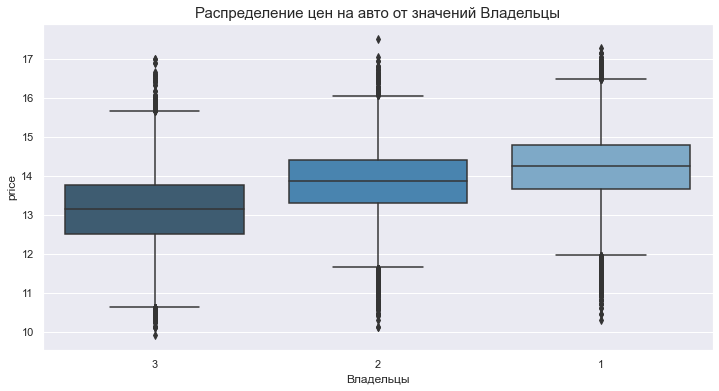

In [63]:
plt.figure(figsize=(12,6))
cat_boxplot('Владельцы', rotation=0)

In [64]:
check_values('Владельцы')

Все уникальные значения test присутствуют в train


In [65]:
train.Владельцы = train.Владельцы.astype('int32')
test.Владельцы = test.Владельцы.astype('int32')

### Владение

In [66]:
# удаляем колонку владение
train.drop('Владение', axis=1, inplace=True)
test.drop('Владение', axis=1, inplace=True)

### ПТС

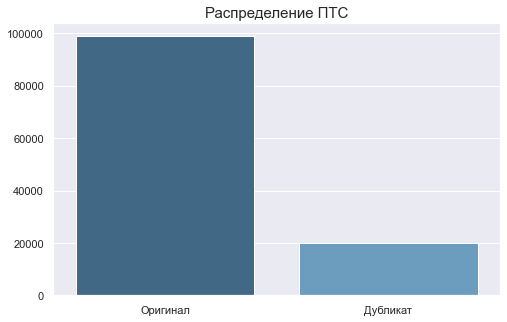

In [67]:
# смотрим на распределение по ПТС (оригинал или дубликат)
cat_plot('ПТС', rotation=0)

В основной массе у автомобилей оригинал ПТС, имеются также машины с дубликатами, но их не так много

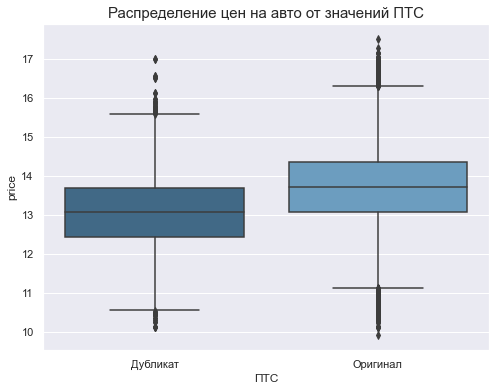

In [68]:
plt.figure(figsize=(8,6))
cat_boxplot('ПТС', rotation=0)

In [69]:
check_values('ПТС')

Все уникальные значения test присутствуют в train


In [70]:
pts_dict = {'Оригинал': 0, 'Дубликат': 1}

train.ПТС = train.ПТС.map(pts_dict)
test.ПТС = test.ПТС.map(pts_dict)

### Привод

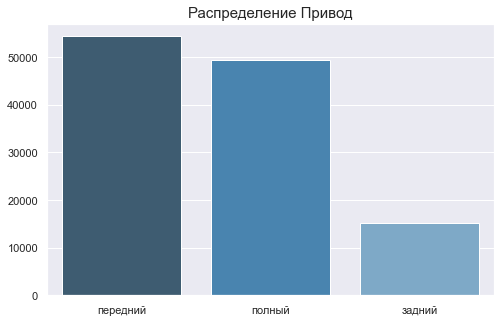

In [71]:
# смотрим на распределение значений по колонке Привод
cat_plot('Привод', rotation=0)

Примерно одинаковое количество машин с передним и полным приводом, они составляют основную массу. Также есть машины с задним приводом

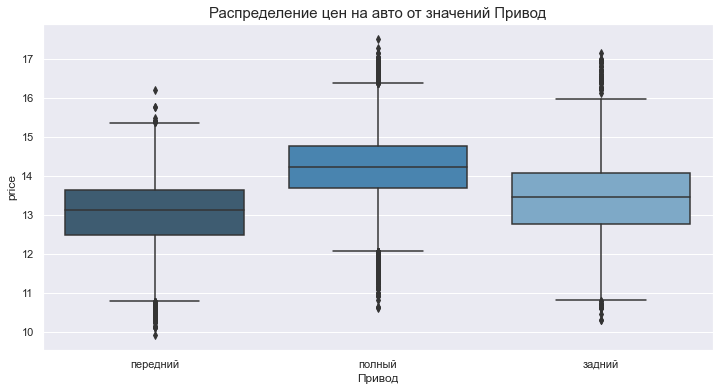

In [72]:
plt.figure(figsize=(12,6))
cat_boxplot('Привод', rotation=0)

In [73]:
check_values('Привод')

Все уникальные значения test присутствуют в train


### Руль

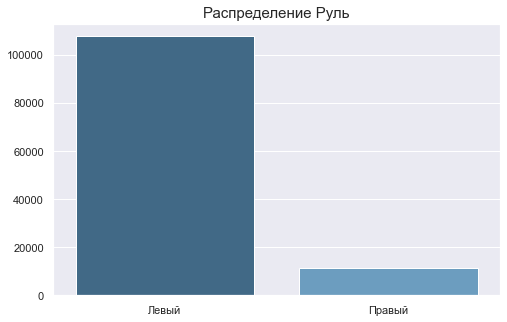

In [74]:
# смотрим на распределение значений по колонке Руль
cat_plot('Руль', rotation=0)

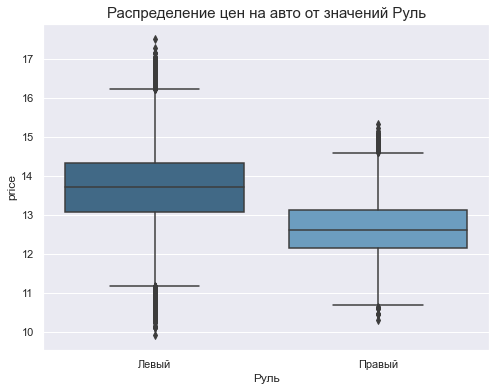

In [75]:
plt.figure(figsize=(8,6))
cat_boxplot('Руль', rotation=0)

In [76]:
check_values('Руль')

Все уникальные значения test присутствуют в train


In [77]:
steering_dict = {'Левый': 0, 'Правый': 1}

train.Руль = train.Руль.map(steering_dict)
test.Руль = test.Руль.map(steering_dict)

Значения колонки Руль мы привели к виду: левый - это 0, правый - 1. Большинство машин с левым рулем и лишь незначительно количество с правым

### Состояние

In [78]:
# смотрим на распределение значений по колонке Состояние
train.Состояние.value_counts()

Не требует ремонта    118746
Битый / не на ходу        13
Name: Состояние, dtype: int64

Имеется только 13 значений битый / не на ходу, остальные машины не требуют ремонта. Значения принимаемые в колонке неинформативны, колонку можно удалить

In [79]:
train.drop(train[train.Состояние == 'Битый / не на ходу'].index, axis=0, inplace=True)
train.reset_index(drop=True, inplace=True)

train.drop('Состояние', axis=1, inplace=True)
test.drop('Состояние', axis=1, inplace=True)


Принимает только одно значение (константа), можно удалить эту колонку

### Таможня

In [80]:
print('train')
display(train.Таможня.value_counts())
print()
print('test')
display(test.Таможня.value_counts())

train


Растаможен       118740
Не растаможен         6
Name: Таможня, dtype: int64


test


Растаможен    34686
Name: Таможня, dtype: int64

In [81]:
train.drop('Таможня', axis=1, inplace=True)
test.drop('Таможня', axis=1, inplace=True)

### Словари

### equipment_dict

In [82]:
train['equipment_dict'] = train['equipment_dict'].str.findall(r"'(\b.*?\b)'")
test['equipment_dict'] = test['equipment_dict'].str.findall(r'"(\b.*?\b)"')

In [83]:
mlb = MultiLabelBinarizer()

In [84]:
equipment_train = mlb.fit_transform(train['equipment_dict'])
equipment_test = mlb.transform(test['equipment_dict'])

equipment_train = pd.DataFrame(data = equipment_train, columns = mlb.classes_)
equipment_test = pd.DataFrame(data = equipment_test, columns = mlb.classes_)

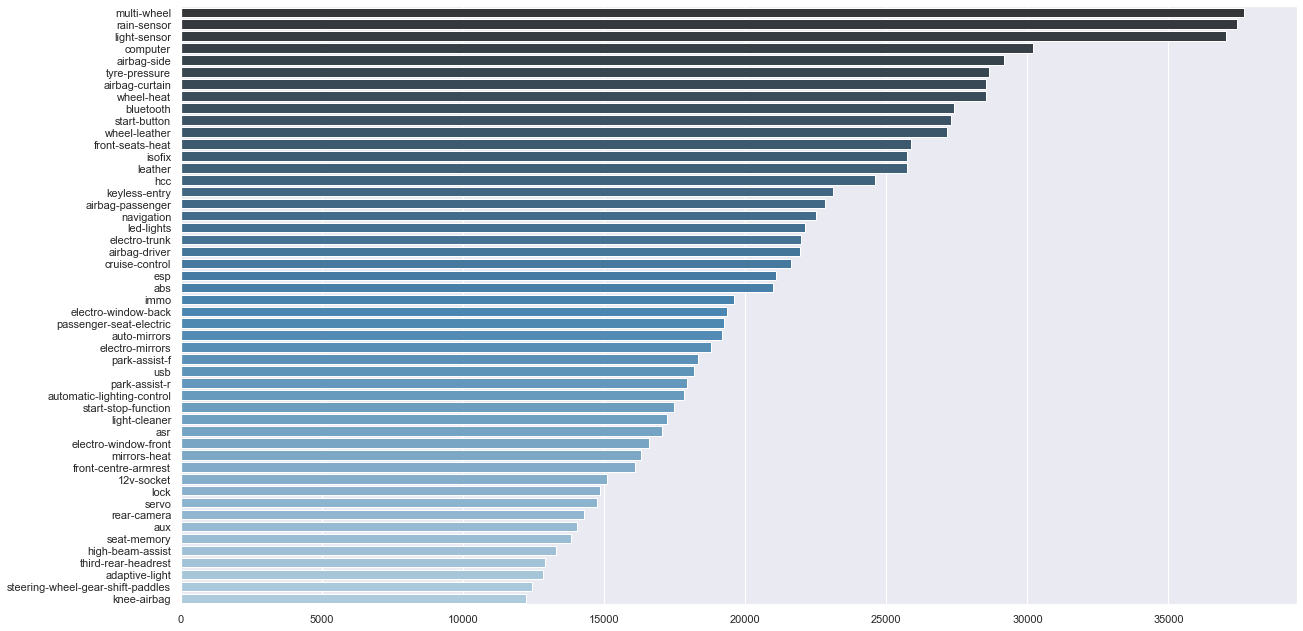

In [85]:
f_scores = f_regression(equipment_train, train.price)[0]
f_scores = pd.Series(f_scores, equipment_train.columns).sort_values(ascending=False)[:50]

plt.figure(figsize=(20,11))
sns.barplot(x=f_scores.values, y=f_scores.index, palette='Blues_r_d');

In [86]:
f_scores_top = f_scores.index

equipment_train = equipment_train[f_scores_top]
equipment_test = equipment_test[f_scores_top]

# Метрика улучшается если не добавлять признаков

In [87]:
train['equipment_count'] = train['equipment_dict'].apply(len)
test['equipment_count'] = test['equipment_dict'].apply(len)

In [88]:
train['equipment_isna'] = train['equipment_count'].astype('bool') * 1
test['equipment_isna'] = test['equipment_count'].astype('bool') * 1

In [91]:
equipment_vc = train['equipment_dict'].explode().value_counts()
equipment_top_lst = equipment_vc.index[:10]
equipment_rare_lst = equipment_vc[equipment_vc < 50].index

In [92]:
train['equipment_top'] = train['equipment_dict'].apply(equipment_top)
test['equipment_top'] = test['equipment_dict'].apply(equipment_top)

train['equipment_rare'] = train['equipment_dict'].apply(equipment_rare)
test['equipment_rare'] = test['equipment_dict'].apply(equipment_rare)

In [93]:
train.drop(columns= ['equipment_dict'], inplace=True)
test.drop(columns= ['equipment_dict'], inplace=True)

### super_gen 

In [94]:
train.drop('super_gen', axis=1, inplace=True)
test.drop('super_gen', axis=1, inplace=True)

## Корреляция

In [95]:
corr = train[num_cols + ['price']].corr()

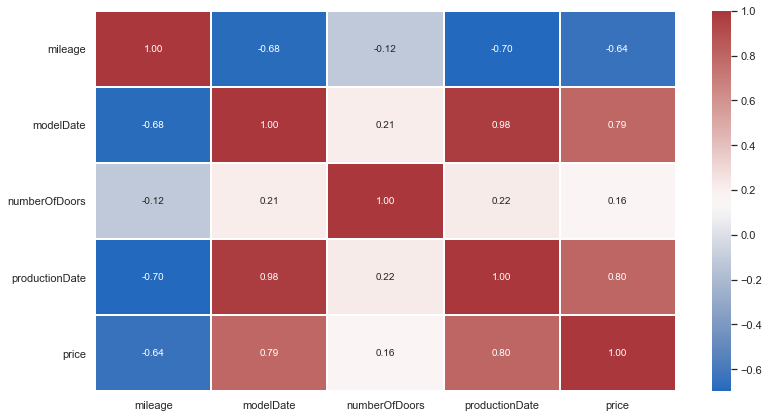

In [96]:
plt.figure(figsize=(13,7))
sns.heatmap(corr, annot=True, cmap='vlag',
            fmt='.2f', linewidths=0.1, annot_kws={"fontsize":10});

### LabelEncoder

In [97]:
coll = ['bodyType', 'brand', 'color']

In [98]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for c in coll:
    train[c] = le.fit_transform(train[[c]])
    test[c] = le.transform(test[[c]])

### OneHotEncoder

In [99]:
df = pd.concat([train, test], axis=0)
df = pd.get_dummies(df)

train = df[~df.price.isna()]
test = df[df.price.isna()]
test = test.drop(columns=['price'])

In [100]:
test.head(2)

,bodyType,brand,color,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,vendor,Владельцы,ПТС,Руль,len_description,tax,model_name_hash,equipment_count,equipment_isna,equipment_top,equipment_rare,fuelType_бензин,fuelType_газ,fuelType_гибрид,fuelType_дизель,fuelType_электро,vehicleTransmission_автоматическая,vehicleTransmission_вариатор,vehicleTransmission_механическая,vehicleTransmission_роботизированная,Привод_задний,Привод_передний,Привод_полный
0,6,8,13,1.2,105,74000,2013,5,2014,0,3,0,0,1001,2625,-0.581159,36,1,9,0,1,0,0,0,0,0,0,0,1,0,1,0
1,6,8,15,1.6,110,60563,2017,5,2017,0,1,0,0,2609,2750,-0.581159,34,1,9,0,1,0,0,0,0,0,0,1,0,0,1,0


In [101]:
train.head(2)

,bodyType,brand,color,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,vendor,Владельцы,ПТС,Руль,price,len_description,tax,model_name_hash,equipment_count,equipment_isna,equipment_top,equipment_rare,fuelType_бензин,fuelType_газ,fuelType_гибрид,fuelType_дизель,fuelType_электро,vehicleTransmission_автоматическая,vehicleTransmission_вариатор,vehicleTransmission_механическая,vehicleTransmission_роботизированная,Привод_задний,Привод_передний,Привод_полный
0,11,0,2,2.3,133,410000,1990,4,1993,0,3,1,0,11.982929,987,4655,0.125428,8,1,2,0,1,0,0,0,0,0,0,1,0,0,1,0
1,11,0,11,2.6,150,350000,1990,4,1993,0,3,0,0,11.918391,483,5250,0.125428,11,1,2,0,1,0,0,0,0,1,0,0,0,0,1,0


In [102]:
# введем новый признак "tax" (расчет годового налога):
train['tax2'] = train.enginePower.apply(lambda x: x*12 if x<=100 
                                           else x*25 if x>100 and x<=125
                                           else x*35 if x>125 and x<=150
                                           else x*45 if x>150 and x<=175
                                           else x*55 if x>175 and x<=200
                                           else x*65 if x>200 and x<=225
                                           else x*75 if x>225 and x<=250
                                           else x*150)


test['tax2'] = test.enginePower.apply(lambda x: x*12 if x<=100 
                                           else x*25 if x>100 and x<=125
                                           else x*35 if x>125 and x<=150
                                           else x*45 if x>150 and x<=175
                                           else x*55 if x>175 and x<=200
                                           else x*65 if x>200 and x<=225
                                           else x*75 if x>225 and x<=250
                                           else x*150)

In [103]:
# преобразуем productionDate в чистый возраст авто:
train['productionDate2'] = 2021 - train['productionDate']
test['productionDate2'] = 2021 - test['productionDate']
train['productionDate2'] = train['productionDate'] .astype(float)
test['productionDate2'] = test['productionDate'] .astype(float)

In [104]:
# преобразуем modelDate в чистый возраст модели:
train['modelDate2'] = 2021 - train['modelDate']
test['modelDate2'] = 2021 - test['modelDate']
train['modelDate2'] = train['modelDate'].astype(float)
test['modelDate2'] = test['modelDate'].astype(float)

In [105]:
test.head(2)

,bodyType,brand,color,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,vendor,Владельцы,ПТС,Руль,len_description,tax,model_name_hash,equipment_count,equipment_isna,equipment_top,equipment_rare,fuelType_бензин,fuelType_газ,fuelType_гибрид,fuelType_дизель,fuelType_электро,vehicleTransmission_автоматическая,vehicleTransmission_вариатор,vehicleTransmission_механическая,vehicleTransmission_роботизированная,Привод_задний,Привод_передний,Привод_полный,tax2,productionDate2,modelDate2
0,6,8,13,1.2,105,74000,2013,5,2014,0,3,0,0,1001,2625,-0.581159,36,1,9,0,1,0,0,0,0,0,0,0,1,0,1,0,2625,2014.0,2013.0
1,6,8,15,1.6,110,60563,2017,5,2017,0,1,0,0,2609,2750,-0.581159,34,1,9,0,1,0,0,0,0,0,0,1,0,0,1,0,2750,2017.0,2017.0


### Проверка значимости признаков

### Числовые

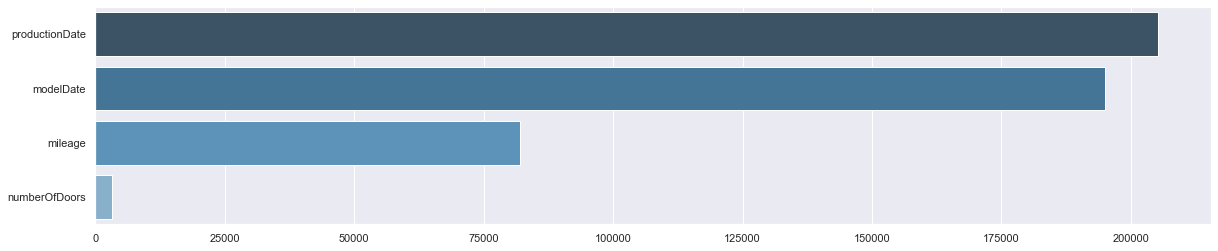

In [106]:
f_scores = f_regression(train[num_cols], train.price)[0]
f_scores = pd.Series(f_scores, num_cols).sort_values(ascending=False)

plt.figure(figsize=(20,4))
sns.barplot(x=f_scores.values, y=f_scores.index, palette='Blues_r_d');

In [107]:
train = train.rename(columns = {'Владельцы': 'Owners', 'ПТС': 'PTC', 'Руль': 'sweel',
                        'fuelType_бензин': 'petrol','fuelType_газ': 'gas', 'fuelType_гибрид': 'hybrid', 
                        'fuelType_дизель': 'disel','fuelType_электро': 'electro', 
                        'vehicleTransmission_автоматическая': 'automatic',
                       'vehicleTransmission_вариатор': 'var',
                       'vehicleTransmission_механическая': 'mech',
                       'vehicleTransmission_роботизированная': 'robot',
                       'Привод_задний': 'rear',
                       'Привод_передний': 'front',
                       'Привод_полный': 'full'}, inplace = False)
test = test.rename(columns = {'Владельцы': 'Owners', 'ПТС': 'PTC', 'Руль': 'sweel',
                        'fuelType_бензин': 'petrol','fuelType_газ': 'gas', 'fuelType_гибрид': 'hybrid', 
                        'fuelType_дизель': 'disel','fuelType_электро': 'electro', 
                        'vehicleTransmission_автоматическая': 'automatic',
                       'vehicleTransmission_вариатор': 'var',
                       'vehicleTransmission_механическая': 'mech',
                       'vehicleTransmission_роботизированная': 'robot',
                       'Привод_задний': 'rear',
                       'Привод_передний': 'front',
                       'Привод_полный': 'full'}, inplace = False)

In [108]:
test= test.drop(columns= ['enginePower', 'disel'])
train= train.drop(columns= ['enginePower', 'disel'])

### Модель

In [109]:
X = train.drop('price', axis=1)
y = train.price

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [111]:
y_test = np.exp(y_test)

In [155]:
import sklearn
print(sklearn.__version__)

0.24.2


### RandomForestRegressor

In [144]:
# param = {'n_estimators': [400],
#          'max_features': ['auto'],
#          'max_depth': [None, 10, 20, 30, 40],
#          'min_samples_split': [1, 2, 5, 10, 20],
#          'min_samples_leaf': [1, 2, 4, 8, 12]}

In [149]:
# rf = RandomForestRegressor(random_state=42)
# rcv = RandomizedSearchCV(estimator=rf, param_distributions=param, cv=3, n_jobs=-1,
#                          scoring='neg_mean_absolute_percentage_error', n_iter=20)

# rcv.fit(X_train, y_train)
# predict = rcv.predict(X_test)
# predict = np.exp(predict)
# MAPE = mean_absolute_percentage_error(y_test, predict) * 100
# MAPE

10.745818452829784

In [150]:
# rcv.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [143]:
rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1, max_features='log2')
rf.fit(X_train, y_train)
predict = rf.predict(X_test)
predict = np.exp(predict)
MAPE = mean_absolute_percentage_error(y_test, predict)
MAPE * 100

10.110458943495969

In [116]:
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.nlargest(20)

modelDate             0.339626
modelDate2            0.298251
tax                   0.082755
tax2                  0.078838
engineDisplacement    0.041895
productionDate        0.024735
productionDate2       0.024489
mileage               0.023126
bodyType              0.021537
front                 0.015834
model_name_hash       0.009354
len_description       0.008085
brand                 0.007600
petrol                0.004712
equipment_count       0.003117
color                 0.002685
automatic             0.002146
vendor                0.001539
numberOfDoors         0.001515
Owners                0.001414
dtype: float64

### ExtraTreesRegressor

In [ ]:
# param = {'n_estimators': [200],
#          'max_features': ['auto'],
#          'max_depth': [None, 10, 20, 30, 40],
#          'min_samples_split': [1, 2, 5, 10, 20],
#          'min_samples_leaf': [1, 2, 4, 8, 12],
#          'bootstrap': [True, False]}

In [ ]:
# etr = ExtraTreesRegressor(random_state=42)
# rcv = RandomizedSearchCV(estimator=etr, param_distributions=param, cv=3, n_jobs=-1,
#                          scoring='neg_mean_absolute_percentage_error', n_iter=20)

# rcv.fit(X_train, y_train)
# predict = rcv.predict(X_test)
# predict = np.exp(predict)
# MAPE = mean_absolute_percentage_error(y_test, predict) * 100
# MAPE

In [ ]:
# rcv.best_params_

In [117]:
etr = ExtraTreesRegressor(n_estimators=500, random_state=42, n_jobs=-1, bootstrap=True)
etr.fit(X_train, y_train)
predict = etr.predict(X_test)
predict = np.exp(predict)
MAPE = mean_absolute_percentage_error(y_test, predict)
MAPE * 100

10.117676928684372

### CatBoostRegressor

In [118]:
# params = {'iterations': [5000],
#           'depth': [None, 4, 5, 6, 7],
#           'l2_leaf_reg': [0.1, 0.4, 1, 3, 5],
#           'random_strength': [0, 0.3, 0.7, 1]}

In [119]:
# cbr = CatBoostRegressor(random_seed=20, loss_function='MAPE', 
#                         eval_metric='MAPE', verbose=0)
# rs_cbr = cbr.randomized_search(params, X, y, cv=3, n_iter=20)
# rs_cbr['params']

In [120]:
cbr = CatBoostRegressor(iterations = 5000,
                        random_seed = 30,
                        loss_function='MAPE',
                        learning_rate=0.06,
                        depth=7,
                        random_strength=0.3,
                        l2_leaf_reg=0.15)

cbr.fit(X_train, y_train,
        eval_set=(X_test, np.log(y_test)),
        verbose_eval=0,
        use_best_model=True);

In [121]:
predict = np.exp(cbr.predict(X_test))
MAPE = mean_absolute_percentage_error(y_test, predict) * 100
MAPE

12.16075817320767

In [122]:
# predict = np.exp(model.predict(test))

In [123]:
# submission = pd.read_csv('sample_submission.csv')
# submission['price'] = predict * 0.90
# # submission.to_csv('submission-1.csv', index=False)
# submission['price'] = np.round(submission['price']*2, -4)/2
# # сохранить в файл
# submission.to_csv('submission-1.csv', index=False)

### LGBMRegressor

In [124]:
# param = {'n_estimators': [2500],
#          'learning_rate': [0.1],
#          'max_depth': [-1, 2, 4, 6],
#          'num_leaves': [20, 30 , 40, 50],
#          'min_child_samples': [None, 5, 10, 20],
#          'lambda_l2': [0.05, 0.1, 0.3, 0.8, 1.5]}

In [125]:
# lgbm = LGBMRegressor(objective='regression', random_state=30)
# rcv = RandomizedSearchCV(estimator=lgbm, param_distributions=param, cv=3, n_jobs=-1,
#                          scoring='neg_mean_absolute_percentage_error', n_iter=15)

# rcv.fit(X_train, y_train)
# predict = rcv.predict(X_test)
# predict = np.exp(predict)
# MAPE = mean_absolute_percentage_error(y_test, predict) * 100
# MAPE

In [126]:
# rcv.best_params_

In [170]:
lgbm = LGBMRegressor(objective='mape', 
                     random_state=30,
                     n_estimators=2500,
                     learning_rate=0.05,
                     lambda_l2=0.5)

lgbm.fit(X_train, y_train,
         eval_set=(X_test, np.log(y_test)))

In [128]:
predict = lgbm.predict(X_test)
predict = np.exp(predict)
MAPE = mean_absolute_percentage_error(y_test, predict) * 100
MAPE

12.51181902562931

### Stacking

In [173]:
estimators = [('cbr', cbr), ('fr', rf), ('etr', etr), ('lgbm', lgbm)]
stacking = StackingRegressor(estimators=estimators,
                             final_estimator=Ridge())
stacking.fit(X_train, y_train)

In [168]:
predict = stacking.predict(X_test)
predict = np.exp(predict)
MAPE = mean_absolute_percentage_error(y_test, predict) * 100
MAPE

10.17226376276189

### Submission

In [169]:
predict = np.exp(stacking.predict(test))

submission = pd.read_csv('sample_submission.csv')
submission['price'] = predict * 0.9
submission.to_csv('submission.csv', index=False)

## Выводы

- RandomForestRegressor - 10.11
- ExtraTreesRegressor - 10.11
- LGBMRegressor - 12.51
- CatBoostRegressor - 12.16
- StackingRegressor  - 10.17


- Kaggle Score - 12.65675

На Kaggle - 21 место
